# Gaussians for DL1r

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
from matplotlib import gridspec

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor as gp

from densityEstimate import *

import os
os.sys.path.append('../code')

from plotting import SR_x, SR_y1, SR_y2
from plotting import CR_x, CR_y1, CR_y2
from plotting import SB_x, SB_y1, SB_y2

%load_ext autoreload
%autoreload 2

Running w/ conda env: don't import root packages.


In [4]:
subDir = 'data16_PFlow-FEB20-5jets'
tag = '_SM_2b_p_0.01'
seedTag = ''
prodTag = 'FEB20'
ntag = 2

lr, beta, N, L, H,h = 1e-3,1e-3,1,1,10,16
cols = ['log_pT_h1','log_pT_h2','eta_h2','eta_h1','log_dphi_hh']

In [5]:
s = f'm_h1>{126-45} & m_h1<{126+45} & m_h2>{116-45} & m_h2<{116+45}'
d = data(5, 16, prodTag, tag, ntag, s)

mask = (d.df.abs_deta_hh < 1.5) 
d.mlPrepare(mask,cols,N=-1)

../data/data16_PFlow-FEB20-5jets/df_SM_2b_p_0.01_2b.h5
Taking 52080 events from 52080 available for the training / validation set


In [11]:
df = d.df

In [15]:
m_hh = 'm_hh_cor2'

mhh_cut = 250

In [13]:
colors=['navy', 'dodgerblue', 'darkturquoise', 'springgreen', 'greenyellow',
        'yellow','orange', 'orangered', 'red']

In [14]:
mh2_edges = np.linspace(116-45,116+45,10)

mh1_edges = np.linspace(126-45,126+45,10) 
mh1_edges

array([ 81.,  91., 101., 111., 121., 131., 141., 151., 161., 171.])

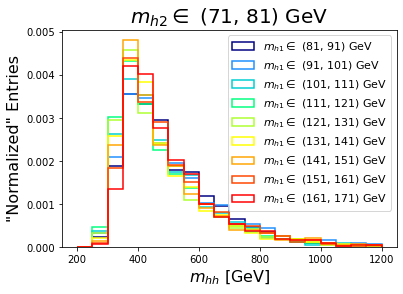

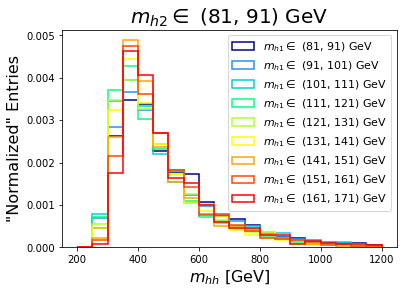

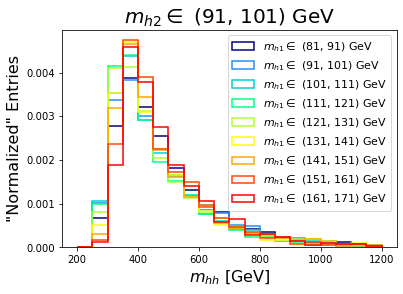

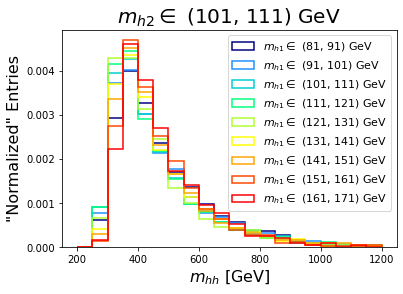

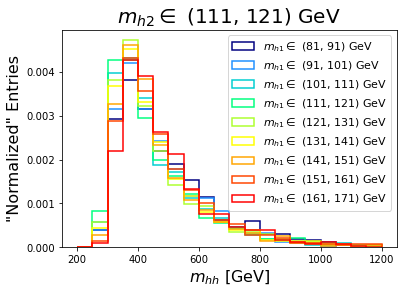

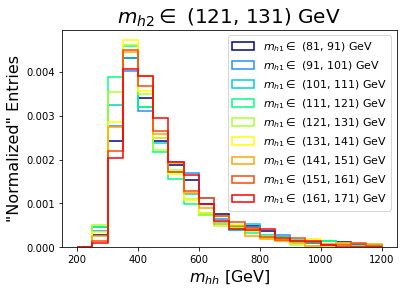

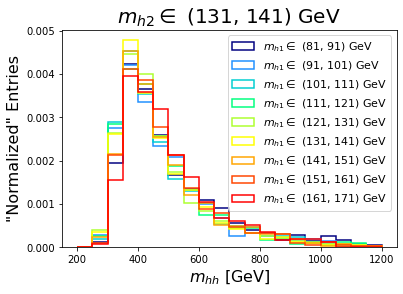

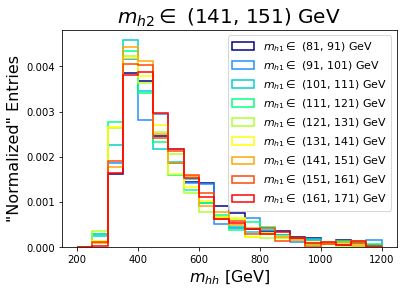

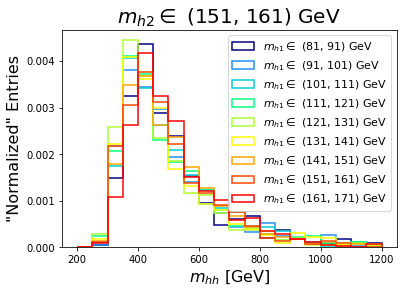

In [16]:
n, mus, stds = {}, {}, {}

for mh2_min, mh2_max in zip(mh2_edges[:-1],mh2_edges[1:]): #= 81,91 #96,101

    mh2_mask = (df.m_h2 > mh2_min) & (df.m_h2 < mh2_max)

    mh2_tag = f'({mh2_min:.0f}, {mh2_max:.0f}) GeV'
    
    n[mh2_tag], mus[mh2_tag], stds[mh2_tag] = [], [], []

    plt.figure()
    
    for c, mh1_min, mh1_max in zip(colors,mh1_edges[:-1],mh1_edges[1:]):

        mh1_mask = (df.m_h1 > mh1_min) & (df.m_h1 < mh1_max)
        mask = (df.ntag==2) & mh1_mask & mh2_mask

        mh1_tag = f'({mh1_min:.0f}, {mh1_max:.0f}) GeV'
        
        plt.hist(df.loc[mask,m_hh],20,(200,1200), linewidth=1.5,
                 histtype='step',color=c, label = r'$m_{h1} \in$ '+mh1_tag,density=True)

        n[mh2_tag].append(np.sum(mask))
        
        x = np.log(df.loc[mask,m_hh]-mhh_cut)
        mus[mh2_tag].append(np.mean(x))
        stds[mh2_tag].append(np.std(x))

    plt.xlabel('$m_{hh}$ [GeV]',fontsize=16)
    plt.ylabel('"Normalized" Entries',fontsize=16)
    plt.title(r'$m_{h2} \in$ '+mh2_tag,fontsize=20)
    plt.legend(bbox_to_anchor=(1,1),loc='upper right',fontsize=11)

    plt.savefig(f'figures/interp3/{m_hh}_mh2_{mh2_min:.0f}_{mh2_max:.0f}_2b.pdf',bbox_inches='tight')
    
    plt.show()

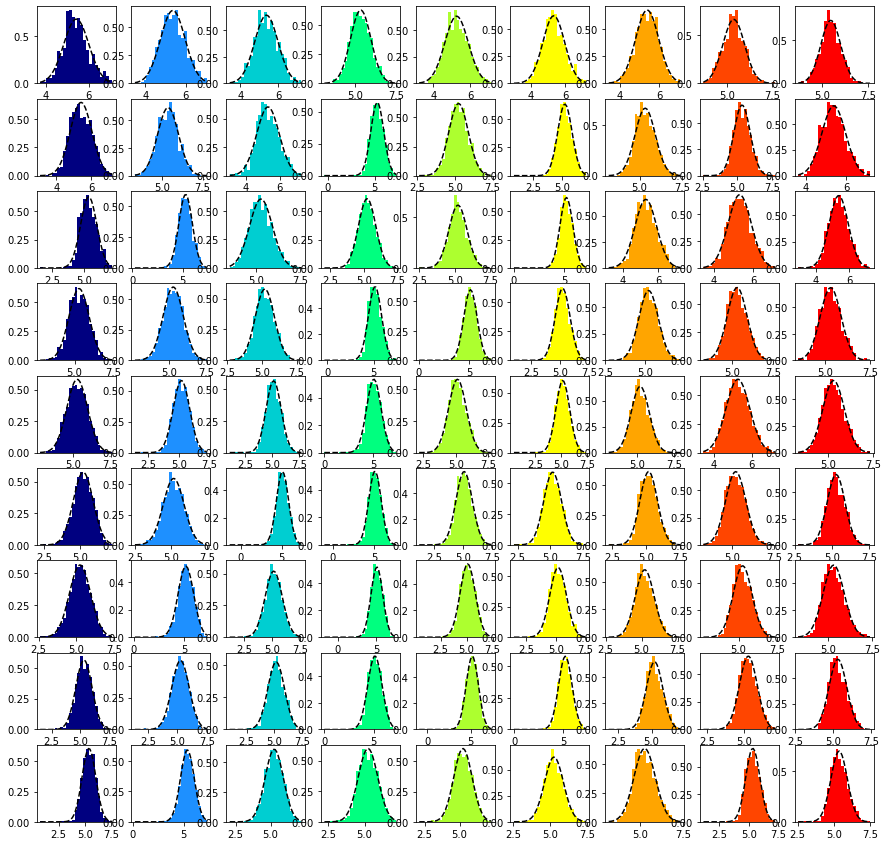

In [17]:
df['box_SR'] = False

fig, axes = plt.subplots(9,9,figsize=(15,15))

'''
The first axis labels the rows, but python indexes from top to bottom, so
need to reverse this to align w/ mh2_edges
'''
for row, mh2_min, mh2_max in zip(axes[::-1],mh2_edges[:-1],mh2_edges[1:]): 

    mh2_mask = (df.m_h2 > mh2_min) & (df.m_h2 < mh2_max)

    for ax, c, mh1_min, mh1_max in zip(row, colors,mh1_edges[:-1],mh1_edges[1:]):
        
        mh1_mask = (df.m_h1 > mh1_min) & (df.m_h1 < mh1_max)
        mask = (df.ntag==2) & mh1_mask & mh2_mask

        mh1_tag = f'({mh1_min:.0f}, {mh1_max:.0f}) GeV'
        
        x = np.log(df.loc[mask,m_hh]-mhh_cut)
        _,e,_ = ax.hist(x,25,color=c,density=True)

        # And do the fit
        mu, std = np.mean(x),np.std(x)
        xi = np.linspace(e[0],e[-1])
        yi = np.exp(-0.5 * ((xi-mu)/std)**2) / (np.sqrt(2*np.pi)*std)
        ax.plot(xi,yi,'k--')
    
        # Store a mask for whether or not this pixel was in the SR
        xi = 0.5*(mh1_min + mh1_max)
        yi = 0.5*(mh2_min + mh2_max)
        if (np.sqrt((10*(xi-120)/xi)**2+(10*(yi-110)/yi)**2) < 1.6):
            df.loc[mask,'box_SR'] = True
    
plt.subplots_adjust()
plt.savefig(f'figures/interp3/fit_{m_hh}_9x9_min_mhh_{mhh_cut}_2b.pdf',
            bbox_inches='tight')
plt.show()